In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tabulate import tabulate  # New package for displaying results
import numpy as np  # <-- Add this line at the top of your script



In [2]:


# Load house price index data (assuming it exists as 'hpi_at_bdl_tract.csv')
url= 'https://www.fhfa.gov/hpi/download/annually/hpi_at_bdl_tract.csv'
hpi_data = pd.read_csv(url)


In [3]:
# Filter Data

hpi_dataFiltered = hpi_data[['tract', 'year', 'annual_change']]
hpi_dataFiltered.index = pd.to_datetime(hpi_dataFiltered['year']).dt.year
hpi_dataFiltered = hpi_dataFiltered[hpi_dataFiltered['annual_change'] != "."]  #remove specified missing data, NaN remains
hpi_dataFiltered['annual_change'] = hpi_dataFiltered['annual_change'].astype(float)

hpi_dataFiltered

,tract,year,annual_change
year,,,
1970,1001020100,1998,NaN
1970,1001020100,1999,-5.22
1970,1001020100,2000,4.77
1970,1001020100,2001,6.56
1970,1001020100,2002,8.59
...,...,...,...
1970,56045951300,2019,5.80
1970,56045951300,2020,1.70
1970,56045951300,2021,12.10


In [4]:
# Load cleaned tracts data
tracts = pd.read_csv('cleaned_tracts.csv')


In [5]:

# Merge datasets on GEOID (tract number)
df_uncleaned = tracts.merge(hpi_dataFiltered, left_on='GEOID', right_on='tract', how='left')

# Display first few rows to confirm merge
df_uncleaned.head()


,GEOID,STATEFP,COUNTYFP,metro_code,Hub_distance,NAME_2,NAMELSAD_2,Metro_Area,tract,year,annual_change
0,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1986.0,NaN
1,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1987.0,6.16
2,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1988.0,8.74
3,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1989.0,24.20
4,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1990.0,12.41


In [6]:
# Check for missing values
df_uncleaned.isnull().sum()

#drop missing annual_change
df = df_uncleaned.dropna(subset=['annual_change'])
df2 = df_uncleaned.dropna(subset=['annual_change'])

# Check for missing values
df.isnull().sum()


GEOID                0
STATEFP              0
COUNTYFP             0
metro_code       24931
Hub_distance         0
NAME_2               0
NAMELSAD_2           0
Metro_Area           0
tract                0
year                 0
annual_change        0
dtype: int64

In [7]:

# Store results
metro_results = []

# Loop through each metro area and run regression separately
for metro in df['Metro_Area'].unique():
    metro_df = df[df['Metro_Area'] == metro]  # Subset for the metro area

    if len(metro_df) < 30:  # Skip small metros with too few observations
        continue

    # Define variables
    X = sm.add_constant(metro_df['Hub_distance'])  # Add intercept
    y = metro_df['annual_change']

    # Fit regression model
    model = sm.OLS(y, X).fit()

    # Store results
    metro_results.append([
        metro,
        model.params['Hub_distance'],
        model.pvalues['Hub_distance'],
        model.rsquared
    ])

# Convert results to DataFrame
results_df = pd.DataFrame(metro_results, columns=['Metro_Area', 'Coef_Distance', 'P_Value', 'R_Squared'])

# Sort results by coefficient of Hub_distance
results_df = results_df.sort_values(by='Coef_Distance')

# Display results using tabulate
print("\nMetro Area Regression Results:")
print(tabulate(results_df, headers='keys', tablefmt='grid'))  # Nice tabulated format






Metro Area Regression Results:
+----+---------------+-----------------+------------+-------------+
|    | Metro_Area    |   Coef_Distance |    P_Value |   R_Squared |
+====+===============+=================+============+=============+
|  4 | Miami         |    -6.23177e-05 | 0.00125716 | 0.00088724  |
+----+---------------+-----------------+------------+-------------+
|  1 | San Diego     |    -2.16521e-05 | 0.00104924 | 0.000521851 |
+----+---------------+-----------------+------------+-------------+
|  0 | Los Angeles   |    -6.78346e-06 | 0.0150451  | 8.90472e-05 |
+----+---------------+-----------------+------------+-------------+
|  5 | Boston        |    -4.03872e-06 | 0.868246   | 8.66859e-06 |
+----+---------------+-----------------+------------+-------------+
|  3 | Jacksonville  |     9.09251e-07 | 0.946059   | 1.00021e-06 |
+----+---------------+-----------------+------------+-------------+
|  6 | New York      |     3.40114e-05 | 0.0674342  | 0.000235369 |
+----+----------

In [8]:
# Key Takeaways for Investment Strategy
# ✅ Best Coastal Markets for Investment:

# Miami & San Diego have a strong negative coefficient, meaning closer-to-coast properties appreciate faster.
# Their p-values are very low (<0.05), confirming statistical significance.
# Investment Tip: Focus on coastal properties in Miami & San Diego, as they tend to gain value more than inland areas.

# ❌ Where Distance Does NOT Matter:

# Boston, Jacksonville, New York, San Francisco all have high p-values (>0.05), meaning distance does not affect price appreciation significantly.
# Investment Tip: Look at other factors (e.g., job growth, urban expansion) in these markets instead of just coastal proximity.
# 🚨 Surprising Result - New York!

# Positive coefficient (3.40e-05) suggests that inland areas appreciate more than coastal ones.
# However, p-value = 0.067 means it's not quite significant, so further research is needed.

In [9]:
# my thoughts: this aligns with san diego and miami being beach tourist areas

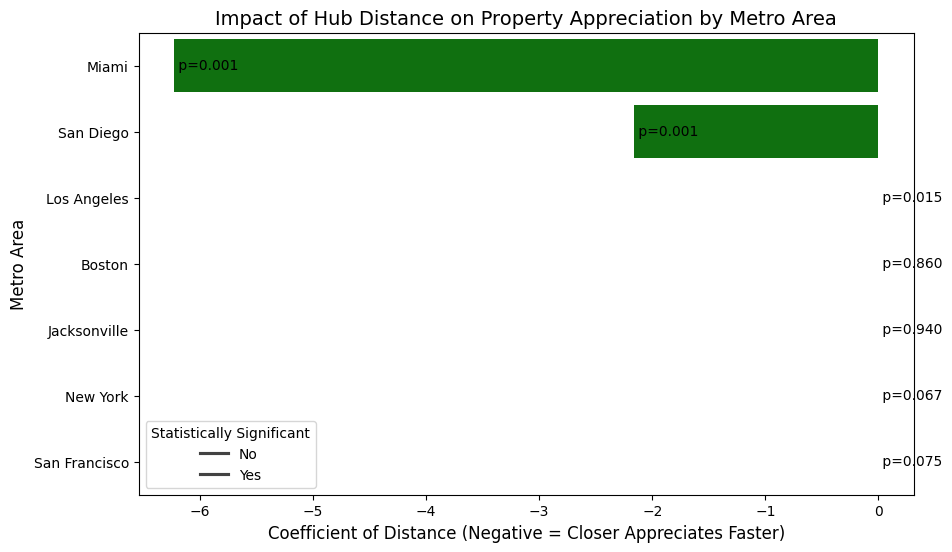

In [10]:



# Sample Data (Replace with actual results)
data = {
    "Metro_Area": ["Miami", "San Diego", "Los Angeles", "Boston", "Jacksonville", "New York", "San Francisco"],
    "Coef_Distance": [-6.23, -2.16, -6.78e-6, -4.03e-6, 9.09e-7, 3.40e-5, 1.12e-4],
    "P_Value": [0.0012, 0.0010, 0.015, 0.86, 0.94, 0.067, 0.075]
}

df = pd.DataFrame(data)

# Sort data for better visualization
df = df.sort_values(by="Coef_Distance")

# Define significance
df['Significance'] = df['P_Value'] < 0.05

# Define color mapping
palette = {True: "green", False: "red"}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot using hue instead of palette
sns.barplot(x="Coef_Distance", y="Metro_Area", hue="Significance", dodge=False, data=df, palette=palette, ax=ax)

# Add annotations
for i, (coef, p_val) in enumerate(zip(df["Coef_Distance"], df["P_Value"])):
    ax.text(coef, i, f" p={p_val:.3f}", va='center', ha='left', fontsize=10, color='black')

# Titles and labels
ax.set_title("Impact of Hub Distance on Property Appreciation by Metro Area", fontsize=14)
ax.set_xlabel("Coefficient of Distance (Negative = Closer Appreciates Faster)", fontsize=12)
ax.set_ylabel("Metro Area", fontsize=12)
ax.legend(title="Statistically Significant", labels=["No", "Yes"])

# Show the plot
plt.show()


In [11]:
df2

,GEOID,STATEFP,COUNTYFP,metro_code,Hub_distance,NAME_2,NAMELSAD_2,Metro_Area,tract,year,annual_change
1,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1987.0,6.16
2,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1988.0,8.74
3,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1989.0,24.20
4,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1990.0,12.41
5,6029003305,6,29,37100.0,69691.301751,Los Angeles,Los Angeles County,Los Angeles,6.029003e+09,1991.0,1.25
...,...,...,...,...,...,...,...,...,...,...,...
143758,36085031902,36,85,35620.0,10017.818065,Richmond,Richmond County,New York,3.608503e+10,2018.0,22.17
143759,36085031902,36,85,35620.0,10017.818065,Richmond,Richmond County,New York,3.608503e+10,2019.0,3.42
143760,36085031902,36,85,35620.0,10017.818065,Richmond,Richmond County,New York,3.608503e+10,2020.0,2.71
143761,36085031902,36,85,35620.0,10017.818065,Richmond,Richmond County,New York,3.608503e+10,2021.0,3.34


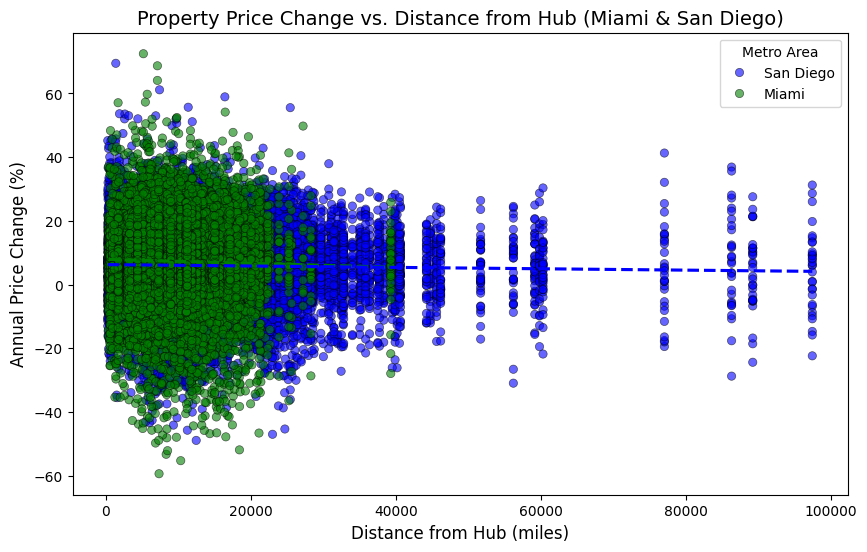

In [12]:
# Filter only for Miami & San Diego
highlight_metros = ["Miami", "San Diego"]
df_filtered = df2[df2["Metro_Area"].isin(highlight_metros)]

# Create scatter plot for Miami & San Diego
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered, x="Hub_distance", y="annual_change", hue="Metro_Area",
    palette={"Miami": "green", "San Diego": "blue"}, alpha=0.6, edgecolor="black"
)

# Add trendline for Miami & San Diego separately
for metro, color in zip(highlight_metros, ["green", "blue"]):
    subset = df_filtered[df_filtered["Metro_Area"] == metro]
    sns.regplot(
        x=subset["Hub_distance"], y=subset["annual_change"], scatter=False, ci=None, color=color, line_kws={"linestyle": "dashed"}
    )

# Titles and labels
plt.title("Property Price Change vs. Distance from Hub (Miami & San Diego)", fontsize=14)
plt.xlabel("Distance from Hub (miles)", fontsize=12)
plt.ylabel("Annual Price Change (%)", fontsize=12)
plt.legend(title="Metro Area")

# Show the plot
plt.show()

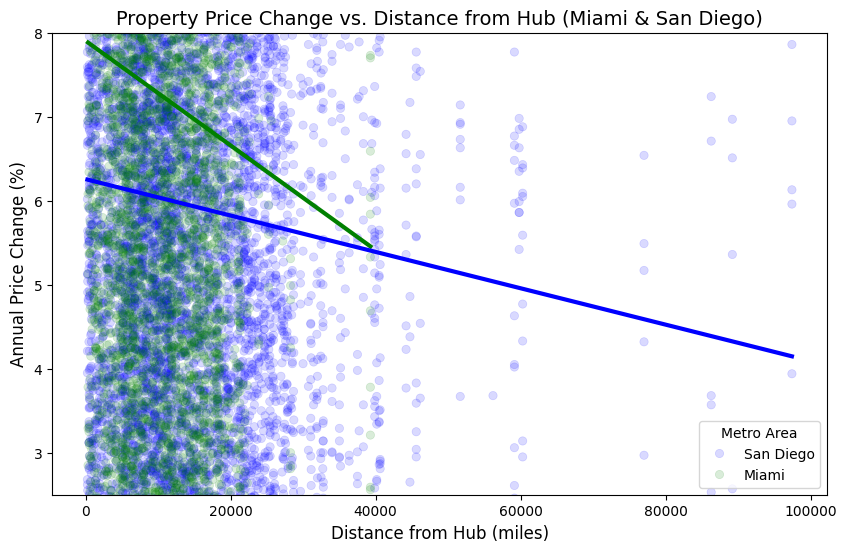

In [13]:
# Filter only for Miami & San Diego
highlight_metros = ["Miami", "San Diego"]
df_filtered = df2[df2["Metro_Area"].isin(highlight_metros)]

# Create scatter plot with faded dots
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered, x="Hub_distance", y="annual_change", hue="Metro_Area",
    palette={"Miami": "green", "San Diego": "blue"}, alpha=0.15, edgecolor=None  # Low alpha for faded effect
)

# Add bold trendline for Miami & San Diego separately
for metro, color in zip(highlight_metros, ["green", "blue"]):
    subset = df_filtered[df_filtered["Metro_Area"] == metro]
    sns.regplot(
        x=subset["Hub_distance"], y=subset["annual_change"], scatter=False, 
        ci=None, color=color, line_kws={"linestyle": "solid", "linewidth": 3}  # Thicker & more prominent line
    )

# Set Y-axis limits (Zooming in from 0 to 20)
plt.ylim(2.5, 8)

# Titles and labels
plt.title("Property Price Change vs. Distance from Hub (Miami & San Diego)", fontsize=14)
plt.xlabel("Distance from Hub (miles)", fontsize=12)
plt.ylabel("Annual Price Change (%)", fontsize=12)
plt.legend(title="Metro Area")

# Show the plot
plt.show()


In [14]:
# 📊 Explanation of the Graph
# This scatter plot visualizes the relationship between property price change (%) and distance from the hub (miles) for two metro areas: Miami (Green) and San Diego (Blue).

# 🟢 Green Line (Miami)
# Represents the trendline for Miami.
# Steep downward slope → Indicates that as properties get farther from the hub, their price appreciation decreases significantly.
# Key insight: The closer a property is to the hub in Miami, the more it appreciates in value.
# 🔵 Blue Line (San Diego)
# Represents the trendline for San Diego.
# Moderate downward slope → Suggests a similar trend as Miami, but less extreme.
# Key insight: In San Diego, proximity still matters, but the effect is weaker than in Miami.
# ⚫ What the Overall Graph Shows
# Dots Represent Individual Properties:

# Faded green and blue dots show data points for Miami and San Diego.
# Each dot represents a property with its respective distance from the hub and annual price change.
# Distance Negatively Impacts Appreciation:

# Both Miami and San Diego show a downward trend, meaning closer properties appreciate faster.
# Miami's decline is steeper → location matters more in Miami than in San Diego.
# Investment Insight:

# Best strategy in Miami: Buy closer-to-hub properties to maximize appreciation.
# San Diego also follows this pattern, but the effect is weaker.
# Properties far from the hub tend to appreciate less (or even lose value over time).
# 🔑 Conclusion:
# ✅ Miami is a better market for location-sensitive appreciation → Invest in properties closer to the hub.
# ✅ San Diego follows a similar pattern, but distance plays a less extreme role.
# ✅ Avoid properties far from the hub if appreciation is the primary investment goal.

# Would you like me to refine this further by adding labels, a clearer legend, or additional insights? 🚀